# Shor's Algorithm

Shor’s algorithm is famous for factoring integers in polynomial time.  The best-developed classical algorithms require superpolynomial time to factor the product of two primes; On the other hand the widely used cryptosystem, RSA, relies on factoring being impossible for large enough integers.

In this Notebook I will focus on the quantum part of Shor’s algorithm that might be applied later on, which solves the problem of 'period finding'. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. If I can compute the period of (a^x)*mod(N) efficiently, then we can also efficiently factor. 

I will first solve the issue of period finding, then discuss how this can be used to factor.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


## Period Finding

I will first look at the periodic function and equation:

$$ f(x) = a^x \bmod{N}$$

where $a$ and $N$ are positive integers, $a$ is less than $N$, and they have no common factors. The period, or order ($r$), is the smallest (non-zero) integer such that:

$$a^r \bmod N = 1 $$ 

I can see an example of this function plotted on the graph below. The lines between points are to help see the periodicity and do not represent the intermedial values along the x-axis. ie it is not a direct slope correlation t the values in computation.

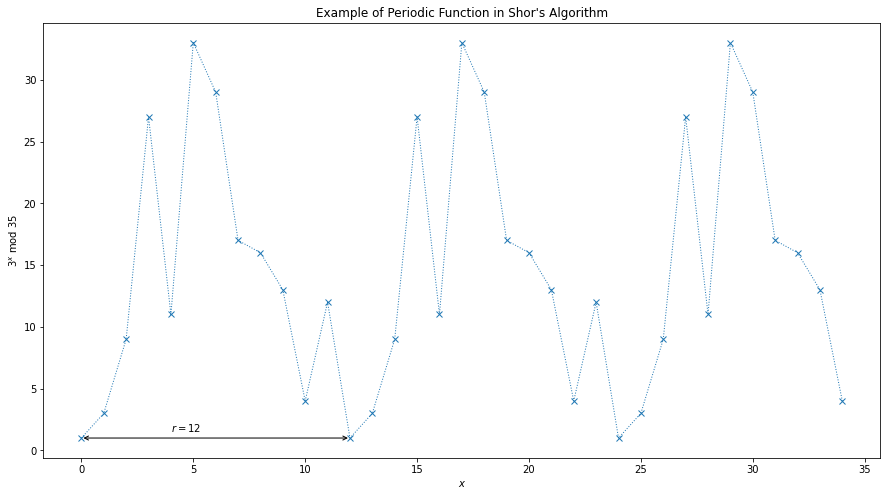

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it 
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

## Our Answer

Shor’s Answer was to use quantum phase estimation on the unitary operand:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

I will work out what an eigenstate of U might look like. If I started in the state $|1\rangle$, I can see that each successive application of U will multiply the state of the register by $a \pmod N$, and after $r$ applications, I will arrive at the state $|1\rangle$ again. For example with $a = 3$ and $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

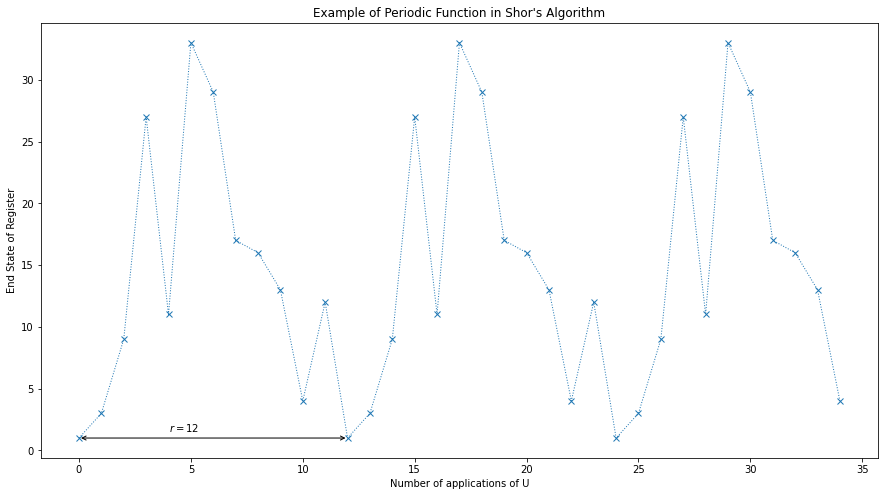

In [3]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='Number of applications of U', ylabel='End State of Register',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

So a superposition of all states inside of this cycle ($|u_0\rangle$) would end up being an eigenstate of $U$:

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$

This eigenstate only has an eigenvalue of 1, which is not of interest to us. A much more relevant eigenstate could be one in which the phase is different or varied for each of these computational basis states. To do this, I will look at the case where the phase of the $k$th state is proportional to that of $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

This eigenvalue is of particular interest seeing as it contains $r$. As a matter of fact, $r$ has to be included to ensure the phase differences between the $r$ computational basis states are equal. To generalise this even more, I can multiply $s$, by this phase difference, which will show up in the eigenvalue:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

I now have a unique eigenstate for each integer value of $s$ where $$0 \leq s \leq r-1$$ If I sum up all these eigenstates, the different phases cancel out all computational basis states except $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

Since the computational basis state $|1\rangle$ is a superposition of these eigenstates, which means if I do QPE on $U$ using the state $|1\rangle$, I will measure a phase of:

$$\phi = \frac{s}{r}$$

Where $s$ is a random integer between $0$ and $r-1$. I finally use the continued fractions algorithm on $\phi$ to find $r$.

I will next show Shor’s algorithm utilizing Qiskit’s simulators. For this I will have given the circuits for $U$ without need for further explaining, but later I will show how circuits for $U^{2^j}$ could be built more efficiently.

## Qiskit Demo

For this example I will solve the period finding problem for $a=7$ and $N=15$. I can provide the circuits for $U$ where:

$$U|y\rangle = |ay\bmod 15\rangle $$

without explanation as stated before.

In [4]:
# To create U^x, we will repeat the circuit x times. 
# the function c_amod15 returns the controlled U gate for a, repeated power times

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [5]:
#I will use 8 counting qubits

# Specify variables
n_count = 8  # number of counting qubits
a = 7

In [6]:
#I also import the circuit for the Quantum Fourier Transform Operation

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

With these building blocks I can easily construct the circuit for Shor's algorithm:

In [7]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

Let's see what results I measure:

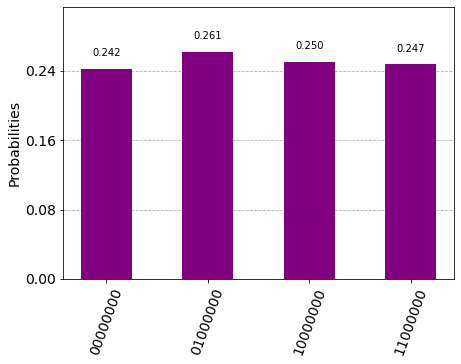

In [8]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts, color='purple')

Since I have 3 qubits, these results correspond to measured phases of:

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


I can now use the continued fractions algorithm to attempt to find 's' and 'r'. Python has this functionality built in: We can use the 'fractions' module to turn a float into a 'Fraction' object, for example:

In [10]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [11]:
#To limit the results append the limit_denominator to under 15, watch how the answer is changed.
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

Much nicer! The order 'r' must be less than 'N', so I will set the maximum denominator to be '15':

In [12]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


The two of the measured eigenvalues provide the correct result: 'r' = 4, although, I can see that Shor’s algorithm has a chance of failing. These bad results are because 's' = 0, or because 's' and 'r' are not coprime and instead of 'r' I am given a factor of 'r'. The easiest solution to this is to simply repeat the experiment until I get a satisfying result for 'r'.

In [13]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


## Modular Exponentiation

The method of creating the $U^{2^j}$ gates by repeating $U$ grows exponentially with $j$ and will not result in a polynomial time algorithm. I need a methof to synthesize the operator:

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

that grows polynomially with $j$. Calculating:

$$ a^{2^j} \bmod N$$

Classical computers can use an algorithm known as _repeated squaring_ to calculate an exponential. However in this case, because I am only dealing with exponentials of the form $2^j$, the repeated squaring algorithm becomes extremely basic to perform:

In [14]:
#Repeated squaring function for my purposes
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [15]:
a2jmodN(7, 2049, 53)

47

My theory is: If an efficient algorithm is possible in Python, then we can use the same algorithm on a quantum computer.

Unfortunately, despite scaling polynomially with `j`, modular exponentiation circuits are not straightforward and are the bottleneck in Shor’s algorithm. ( understanding it )

# Factoring from Period Finding

I can spot an even number instantly and know that one of its factors is 2. In fact, there are 'specific criteria'.
for choosing numbers that are difficult to factor, but the basic idea is to choose the product of two large prime numbers. A general factoring algorithm will first check to see if there is a shortcut to factoring the integer (is the number even? Is the number of the form 'N' = a^b?), before using Shor’s period finding for the worst-case scenario. Since I aim to focus on the quantum part of the algorithm, I will jump straight to the case in which 'N' is the product of two primes.

Ex: Factoring 15

To see an example of factoring on a small number of qubits, I will factor 15, which I all know is the product of the not-so-large prime numbers 3 and 5.

In [16]:
N = 15

The first step is to choose a random number, 'x', between 1 and 'N-1':

In [17]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


Next I quickly check it isn't already a non-trivial factor of 'N':

In [18]:
from math import gcd # greatest common divisor
gcd(a, N)

1

Next, I do Shor's order finding algorithm for `a = 7` and `N = 15`. Remember that the phase I measure will be `s / r` where:

`(a^r)*mod(N) = 1`

and `s` is a random integer between `0` and `r-1`.

In [19]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    qasm_sim = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, qasm_sim)
    obj = assemble(t_qc, shots=1)
    result = qasm_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

From this phase, I can easily find a guess for `r`:

In [20]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 01000000
Corresponding Phase: 0.250000


Fraction(1, 4)

In [21]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


Now I have $r$, I possibly am able to utilize this to determine a factor of $N$. Seeing as:

$$a^r \bmod N = 1 $$

then:

$$(a^r - 1) \bmod N = 0 $$

which mean $N$ has to divide $a^r-1$. And if $r$ is also even, then I can say:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(if $r$ isn't even, I cannot go farther and have to try once more with a different value for $a$). Then there is a high probability that the GCD of $N$ and either $a^{r/2}-1$, or $a^{r/2}+1$ is a true factor of $N$:

In [22]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


The cell below repeats the algorithm until at least one factor of 15 is found. Re-run to see how this behaves:

In [23]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


The answers are the  non-trivial factors, these are the factors of $N$ used for the RSA algortihm and key generation.

## References

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)

3. qiskit.org/learn, A great resource for all things Qiskit